In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from testing import test
from train import train

### 1. SUMO Visualizations

### 2. The macro environment 

The macro envorinment is based on taxi record data colleted in various city, e.g. New York City, San Francisco, Washignton DC, Shenzhen. In each scenarion, the road network is segmented into stations by clustering junctions such that the travel time within each station is upper-bounded by a given error tolerance. 

<img src="figures/washington_dc.png" alt="drawing" width="250"/>

In this notebook, we are looking at the nyc brooklyn scenario. The graph consits of 14 nodes with the following aggregated demand distributin over on epsisode:

***Graph for the NYC Brooklyn Data - Aggregated Demand***

<img src="figures/graph_nyc_2.png" alt="drawing" width="400"/>

## 3. Baselines

This repository provides a set of baseline policies, that aim to outperform the no-control policy, which serves as the lower bound. 
The simplest of these is the random rebalancing policy. We evaluate its performance against the no-control policy by assessing total profit, calculated as the profit from passengers served minus the cost of rebalancing.

  0%|          | 0/10 [00:00<?, ?it/s]

Testing model random on macro environment


Test Episode 10 | Reward: 30033.68 | ServedDemand: 51091.68 | Reb. Cost: 21058.00: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

Mean Episode Profit ($):  25781.227479491667
Mean Episode Served Demand- Proit($):  48025.22747949166
Mean Episode Rebalancing Cost($):  22244.0


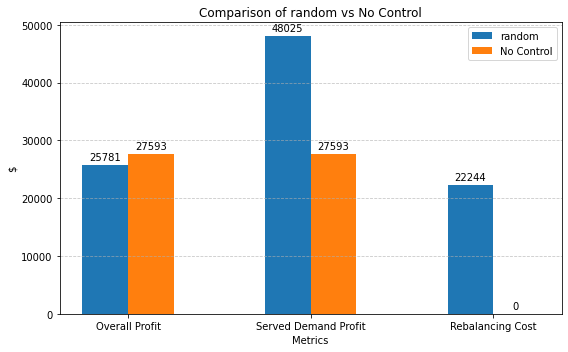

In [16]:
config = {
    "simulator.name": "macro",
    "model.name": "random",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
test(config)

### Implement your own controller

The random rebalancing policy is not able to outperform the no control baseline. Let's implement one that does. We can impelemnt a control policy, which tries to reach an equal distribution of vehicles in the network with the minmial rebalancing cost.

Can you do it? 

In [ ]:
from src.misc.utils import dictsum
from src.algos.reb_flow_solver import solveRebFlow
from src.algos.base import BaseAlgorithm


class EqualDistribution(BaseAlgorithm):
    def __init__(self, **kwargs):
        """
        :param cplexpath: Path to the CPLEX solver.
        """
        self.cplexpath = kwargs.get('cplexpath') #None, for no CPLEX
        self.directory = kwargs.get('directory')

    def select_action(self, env):
        """
        Implements the Equal Distribution (ED) baseline for rebalancing.
        """
        #determines the desired vehicle distirbutions
        nregions = env.nregion # number of regions in this scenario
        
        action = TODO
        
        #calculates the desirebd number of vehicles in each region
        desired_acc = {
            env.region[i]: int(action[i] * dictsum(env.acc, env.time +1))
            for i in range(len(env.region))
        }

        #calculated the min-cost rebalancing flow to reach desried distirbution
        reb_action = solveRebFlow(env, self.directory, desired_acc, self.cplexpath) 
        
        return reb_action

When done compare your result to the actual impelementation of the equal distribution baseline in **src/algos/ed.py** and observe the performance:

  0%|          | 0/1 [00:00<?, ?it/s]

Testing model equal_distribution on macro environment


Test Episode 1 | Reward: 47922.52 | ServedDemand: 58446.52 | Reb. Cost: 10524.00: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

Mean Episode Profit ($):  47922.518415573475
Mean Episode Served Demand- Proit($):  58446.518415573475
Mean Episode Rebalancing Cost($):  10524.0


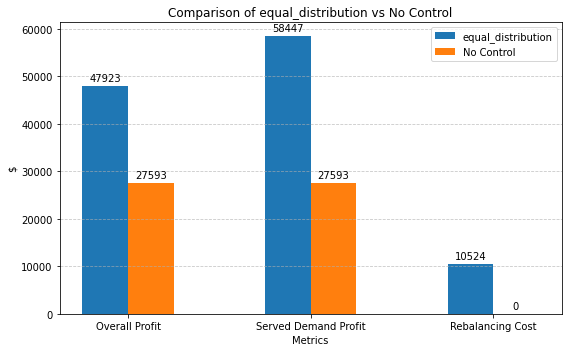

In [4]:
config = {
    "simulator.name": "macro",
    "model.name": "equal_distribution",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 1,
}
test(config)

## 4. RL-based policies 

  0%|          | 0/10 [00:00<?, ?it/s]

Testing model sac on macro environment


Test Episode 10 | Reward: 56139.15 | ServedDemand: 69751.15 | Reb. Cost: 13612.00: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]

Mean Episode Profit ($):  56743.10614914915
Mean Episode Served Demand- Proit($):  70466.30614914915
Mean Episode Rebalancing Cost($):  13723.2


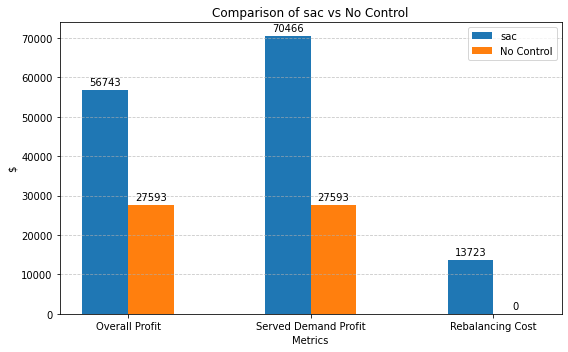

In [21]:
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn", 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_nyc_brooklyn"
}
test(config)

  0%|          | 0/10 [00:00<?, ?it/s]

Testing model sac on macro environment


Test Episode 10 | Reward: 56493.05 | ServedDemand: 70149.05 | Reb. Cost: 13656.00: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]

Mean Episode Profit ($):  56741.53123869118
Mean Episode Served Demand- Proit($):  70555.13123869117
Mean Episode Rebalancing Cost($):  13813.6


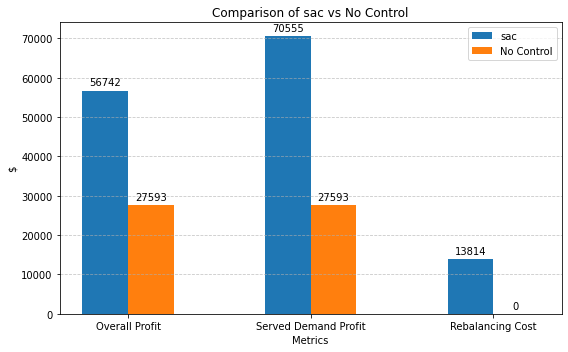

In [23]:
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn", 
    "model.test_episodes": 10,
    "model.cplexpath": None,
    "model.checkpoint_path": "SAC_nyc_brooklyn"
}
test(config)

In [3]:
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn", 
    "model.test_episodes": 10,
    "model.cplexpath": None,
    "model.checkpoint_path": "SAC_nyc_brooklyn_seed5"
}
test(config)

  0%|          | 0/10 [00:00<?, ?it/s]

Testing model sac on macro environment


Test Episode 2 | Reward: 57828.42 | ServedDemand: 71816.42 | Reb. Cost: 13988.00:  20%|██        | 2/10 [00:03<00:14,  1.75s/it]

### Implement an RL agent

Generally an actor takes the current state as input and outputs the next action: 

In [5]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Dirichlet

class Actor(nn.Module):
    """
    Actor \pi(a_t | s_t) parametrizing the concentration parameters of a Dirichlet Policy.
    """

    def __init__(self, in_channels, act_dim, hidden_size=32):
        super().__init__()
      
        self.lin1 = nn.Linear(in_channels, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, act_dim)

    def forward(self, state):
        x = F.relu(self.lin1(state))
        x = F.relu(self.lin2(x))
        x = F.softplus(self.lin3(x))
    
        concentration = x.squeeze(-1)
    
        m = Dirichlet(concentration + 1e-20)
        
        action = m.rsample()
        return action

In [6]:
import torch
'''
The state consits of 14 nodes with 13 node features
'''
state = torch.ones(14, 13) 

state = state.flatten()

actor = Actor(in_channels=14*13, act_dim=14)

action = actor(state)

action.shape

torch.Size([14])

In [9]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Dirichlet
from torch_geometric.nn import GCNConv

class GNNActor(nn.Module):
    """
    Actor \pi(a_t | s_t)
    """

    def __init__(self, in_channels, hidden_size=32):
        super().__init__()
        TODO
        self.lin1 = nn.Linear(in_channels, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, edge_index):
        TODO
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.softplus(self.lin3(x))
        
        concentration = x.squeeze(-1)

        m = Dirichlet(concentration + 1e-20)
        action = m.rsample()

        return action

In [ ]:
state = torch.ones(14, 13) 
#edge_index = 
actor = GNNActor(in_channels=13)

action = actor(state)

action.shape

When done you can compare to the actual implementation in src/nets/actor.py

### Train an RL agent

In [14]:
from train import train
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_custom",
    "model.max_episodes": 5,
}
train(config)

  0%|          | 0/5 [00:00<?, ?it/s]

Episode 5 | Reward: 42646.00 | ServedDemand: 51787.00 | Reb. Cost: 9141.00: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

Testing model sac on macro environment


Test Episode 10 | Reward: 50088.55 | ServedDemand: 61254.55 | Reb. Cost: 11166.00: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]

Mean Episode Profit ($):  50507.090610329826
Mean Episode Served Demand- Proit($):  61834.290610329816
Mean Episode Rebalancing Cost($):  11327.2


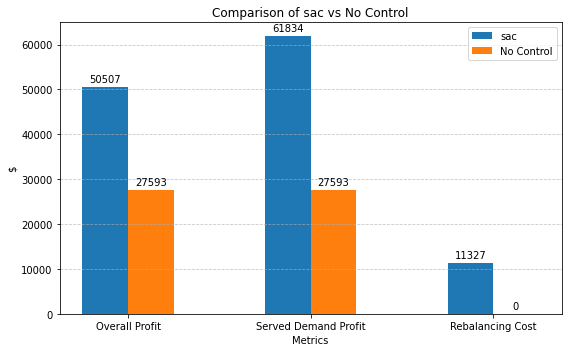

In [20]:
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_custom",
}
test(config)